<a href="https://colab.research.google.com/github/aashi-chatterjee/EV-battery-health-prediction/blob/main/battery_health_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Week 1

In [ ]:
import scipy.io
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style('whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
COLAB_FILE_PATH = '/content/drive/MyDrive/NASA_Battery_Data'

Loading The Data:

In [ ]:
def load_nasa_mat_file(battery_name, file_path='.'):
    mat_file_path = os.path.join(file_path, f"{battery_name}.mat")
    print(f"Loading {mat_file_path}...")

    try:
        mat_file = scipy.io.loadmat(mat_file_path)
    except FileNotFoundError:
        print(f"Error: {battery_name}.mat not found in {file_path}")
        print("Please ensure the .mat files are in the specified directory.")
        return pd.DataFrame()

    try:
        # Access the nested struct: mat_file['B0005'][0, 0]['cycle'][0]
        cycle_array = mat_file[battery_name][0, 0]['cycle'][0]
    except KeyError:
        print(f"Error: Could not find key '{battery_name}' in the .mat file.")
        return pd.DataFrame()

    all_cycle_data_list = []

    for i in range(len(cycle_array)):
        cycle = cycle_array[i]
        mode_array = cycle['type']
        while isinstance(mode_array, np.ndarray):
            #to get the first item
            mode_array = mode_array.flat[0]
        mode = str(mode_array)

        data_struct = cycle['data'][0, 0]

        # Skip if data is empty
        if 'Voltage_measured' not in data_struct.dtype.names:
            continue

        df_cycle = pd.DataFrame({
            'voltage_charger': data_struct['Voltage_measured'].flatten(),
            'current_charger': data_struct['Current_measured'].flatten(),
            'relative_time': data_struct['Time'].flatten(),
            'temperature': data_struct['Temperature_measured'].flatten()
        })

        df_cycle['cycle_number'] = i + 1

        if mode == 'charge':
            df_cycle['mode'] = 1
        elif mode == 'discharge':
            df_cycle['mode'] = -1
        else:
            df_cycle['mode'] = 0

        all_cycle_data_list.append(df_cycle)

    if not all_cycle_data_list:
        print(f"Warning: No valid cycle data found for {battery_name}.")
        return pd.DataFrame()

    final_df = pd.concat(all_cycle_data_list, ignore_index=True)
    final_df['battery_name'] = battery_name.replace('B00', 'B')

    print(f"Successfully loaded and parsed {battery_name}. {final_df.shape[0]} data points.")
    return final_df

In [ ]:
df_B5_raw = load_nasa_mat_file('B0005', file_path=COLAB_FILE_PATH)
df_B7_raw = load_nasa_mat_file('B0007', file_path=COLAB_FILE_PATH)
df_B18_raw = load_nasa_mat_file('B0018', file_path=COLAB_FILE_PATH)

df_raw = pd.concat([df_B5_raw, df_B7_raw, df_B18_raw], ignore_index=True)

print(f"\nLoaded {df_raw.shape[0]} total raw data points.")
print("-" * 50)

Loading /content/drive/MyDrive/NASA_Battery_Data/B0005.mat...
Successfully loaded and parsed B0005. 591458 data points.
Loading /content/drive/MyDrive/NASA_Battery_Data/B0007.mat...
Successfully loaded and parsed B0007. 591458 data points.
Loading /content/drive/MyDrive/NASA_Battery_Data/B0018.mat...
Successfully loaded and parsed B0018. 314676 data points.

Loaded 1497592 total raw data points.
--------------------------------------------------


In [ ]:
df_raw.head()

,voltage_charger,current_charger,relative_time,temperature,cycle_number,mode,battery_name
0,3.873017,-0.001201,0.000,24.655358,1,1,B05
1,3.479394,-4.030268,2.532,24.666480,1,1,B05
2,4.000588,1.512731,5.500,24.675394,1,1,B05
3,4.012395,1.509063,8.344,24.693865,1,1,B05
4,4.019708,1.511318,11.125,24.705069,1,1,B05


In [ ]:
df_raw.isnull().sum()

,0
voltage_charger,2
current_charger,2
relative_time,0
temperature,2
cycle_number,0
mode,0
battery_name,0


In [ ]:
print(df_raw['mode'].unique())
print(df_raw.head())

[ 1 -1]
   voltage_charger  current_charger  relative_time  temperature  cycle_number  \
0         3.873017        -0.001201          0.000    24.655358             1   
1         3.479394        -4.030268          2.532    24.666480             1   
2         4.000588         1.512731          5.500    24.675394             1   
3         4.012395         1.509063          8.344    24.693865             1   
4         4.019708         1.511318         11.125    24.705069             1   

   mode battery_name  
0     1          B05  
1     1          B05  
2     1          B05  
3     1          B05  
4     1          B05  


FEATURE ENGINEERING (dQ/dV Calculation):



In [ ]:
print("Starting dQ/dV feature engineering...")

def calculate_dqdv(cycle_data, V_start=3.0, V_end=4.2, num_points=200):
    # Calculateing the dQ/dV curve for a single charge cycle.

    #Filtering for charge phase
    charge_data = cycle_data[cycle_data['mode'] == 1].copy()
    if charge_data.empty:
        return np.full(num_points, np.nan)

    #Sorting and compute capacity (Q)
    charge_data.sort_values(by='voltage_charger', inplace=True)
    time_diff = charge_data['relative_time'].diff().fillna(0)
    current = charge_data['current_charger']
    charge_data['Q'] = (current * time_diff / 3600).cumsum()

    #Dropping duplicates
    df_clean = charge_data.drop_duplicates(subset=['voltage_charger'], keep='first').copy()
    V = df_clean['voltage_charger'].values
    Q = df_clean['Q'].values

    MIN_POINTS = 10
    if len(V) < MIN_POINTS:
        return np.full(num_points, np.nan)

    #Interpolating Q(V) onto a uniform grid
    V_grid = np.linspace(V_start, V_end, num_points)
    Q_interp_func = interp1d(V, Q, kind='linear', bounds_error=False, fill_value="extrapolate")
    Q_interp = Q_interp_func(V_grid)

    #Computing dQ/dV using Savitzky–Golay smoothing derivative
    window_length = 5
    polyorder = 3

    if np.isnan(Q_interp).all():
        return np.full(num_points, np.nan)
    else:
        Q_interp = np.nan_to_num(Q_interp, nan=0)
        dQdV = savgol_filter(Q_interp, window_length, polyorder, deriv=1, delta=V_grid[1] - V_grid[0])

    return dQdV

def calculate_target_capacity(cycle_data):
    # Calculating the discharged capacity (Ah) for a single discharge cycle.
    discharge_data = cycle_data[cycle_data['mode'] == -1]
    if discharge_data.empty:
        return np.nan

    time_diff = discharge_data['relative_time'].diff().fillna(0)
    current = discharge_data['current_charger']
    capacity = (current * time_diff / 3600).sum() * -1

    if capacity > 1.0:
        return capacity
    else:
        return np.nan

all_features_list = []
all_cycle_info_list = []
rejection_reasons = {'Bad dQ/dV': 0, 'Bad Target': 0, 'Empty Discharge': 0, 'Other': 0}

grouped = df_raw.groupby(['battery_name', 'cycle_number', 'mode'])

battery_cycle_features = {}
battery_cycle_capacity = {}

# Computing dQ/dV and capacities separately
for (battery_name, cycle_num, mode), cycle_data in grouped:
    try:
        if mode == 1:
            dQdV_vector = calculate_dqdv(cycle_data)
            if not np.isnan(dQdV_vector).all():
                battery_cycle_features[(battery_name, cycle_num)] = dQdV_vector
            else:
                rejection_reasons['Bad dQ/dV'] += 1

        elif mode == -1:
            target_capacity = calculate_target_capacity(cycle_data)
            if not np.isnan(target_capacity) and target_capacity > 0:
                battery_cycle_capacity[(battery_name, cycle_num)] = target_capacity
            else:
                rejection_reasons['Bad Target'] += 1

    except Exception as e:
        rejection_reasons['Other'] += 1
        continue

# Pairing each charge cycle with the following discharge
for (battery_name, cycle_num), dQdV_vector in battery_cycle_features.items():
    next_discharge = [
        key for key in battery_cycle_capacity.keys()
        if key[0] == battery_name and key[1] >= cycle_num
    ]
    if next_discharge:
        discharge_key = sorted(next_discharge, key=lambda x: x[1])[0]
    else:
        discharge_key = None

    if discharge_key:
        capacity = battery_cycle_capacity[discharge_key]
        all_features_list.append(dQdV_vector)
        all_cycle_info_list.append({
            'Battery': battery_name,
            'Cycle': cycle_num,
            'Capacity': capacity
        })
    else:
        rejection_reasons['Empty Discharge'] += 1

X_dQdV_features = np.array(all_features_list)
df_cycle_info = pd.DataFrame(all_cycle_info_list)
df_features = pd.concat([df_cycle_info.reset_index(drop=True),
                         pd.DataFrame(X_dQdV_features)], axis=1)

total_rejects = sum(rejection_reasons.values())

print("\n--- FEATURE ENGINEERING SUMMARY ---")
print(f"Total cycles rejected: {total_rejects}")
print("Rejection Breakdown:")
print(pd.Series(rejection_reasons))
print(f"Feature engineering complete. {df_features.shape[0]} valid cycles processed.")
print(f"Feature matrix shape (X): {X_dQdV_features.shape}")
print("-" * 50)

Starting dQ/dV feature engineering...

--- FEATURE ENGINEERING SUMMARY ---
Total cycles rejected: 2
Rejection Breakdown:
Bad dQ/dV          2
Bad Target         0
Empty Discharge    0
Other              0
dtype: int64
Feature engineering complete. 472 valid cycles processed.
Feature matrix shape (X): (472, 200)
--------------------------------------------------


Week 2 : EXPLORATORY DATA ANALYSIS (EDA)

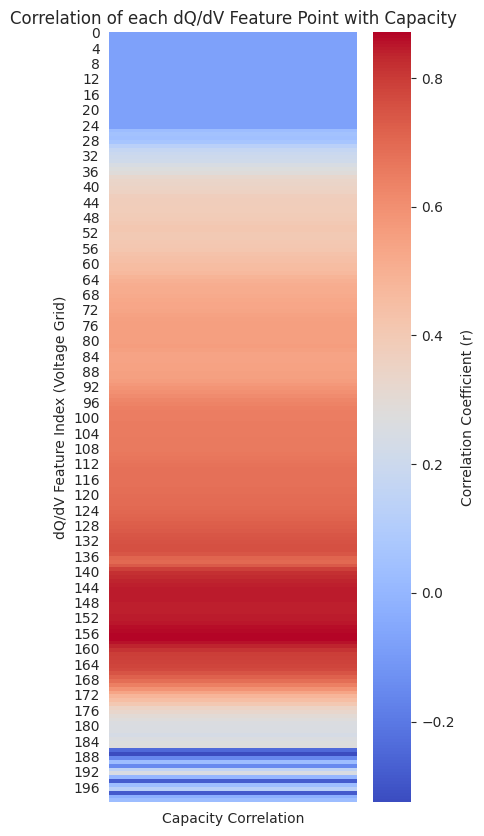

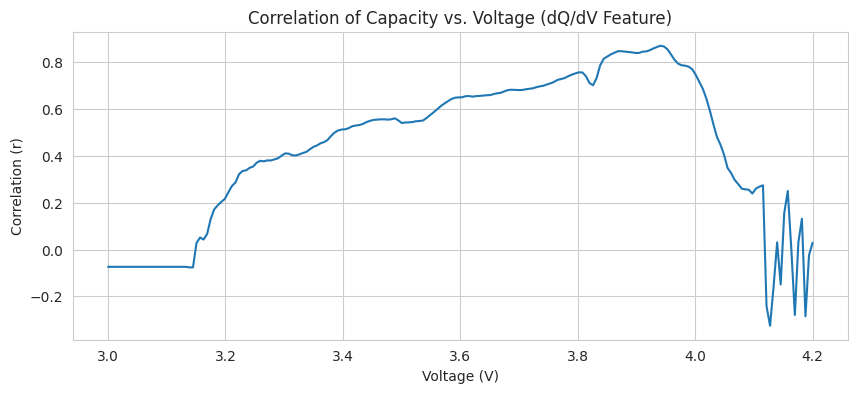

In [ ]:
# Feature-Target Correlation Heatmap

# Global Constants
V_start = 3.0
V_end = 4.2
num_points = 200
V_grid = np.linspace(V_start, V_end, num_points)
FEATURE_START_COL = 3
EOL_THRESHOLD = 2.0 * 0.7

# Calculating correlations between all dQ/dV features and the Capacity target
corr_matrix = df_features.iloc[:, FEATURE_START_COL:].corrwith(df_features['Capacity']).to_frame('Capacity Correlation')

# Plotting the Correlation Map
plt.figure(figsize=(4, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient (r)'})
plt.title('Correlation of each dQ/dV Feature Point with Capacity')
plt.ylabel('dQ/dV Feature Index (Voltage Grid)')
plt.yticks(rotation=0)
plt.show()

# To plot the correlation visually on the V_grid for better understanding:
plt.figure(figsize=(10, 4))
plt.plot(V_grid, corr_matrix['Capacity Correlation'].values)
plt.title('Correlation of Capacity vs. Voltage (dQ/dV Feature)')
plt.xlabel('Voltage (V)')
plt.ylabel('Correlation (r)')
plt.grid(True)
plt.show()

--- EDA START: Generating Visualization Deliverables ---
[EDA 1] Plotting Capacity Degradation...


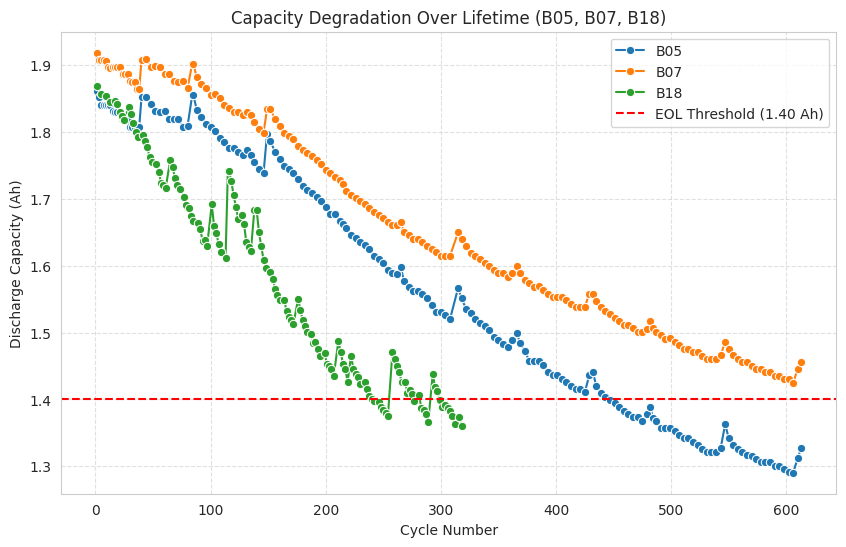


[EDA 2] Plotting dQ/dV Curve Evolution...


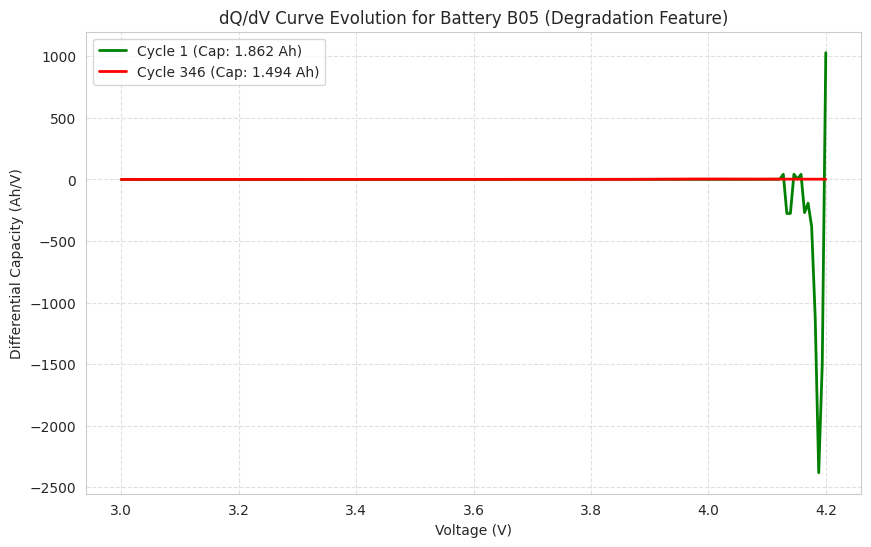


[EDA 3] Summary Statistics and Data Quality Check...
Cycles with missing dQ/dV data: 0
Cycles with missing Capacity data: 0
--------------------------------------------------
Summary Statistics for Capacity (Ah):
         count       min       max      mean
Battery                                     
B05        169  1.290457  1.861941  1.578792
B07        169  1.424683  1.918651  1.668979
B18        134  1.360592  1.868494  1.573536


In [ ]:
print("--- EDA START: Generating Visualization Deliverables ---")

# --- EDA 1: Capacity Fade Analysis (The Target Variable) ---
print("[EDA 1] Plotting Capacity Degradation...")

plt.figure(figsize=(10, 6))
# Plot Capacity vs. Cycle, separated by Battery
sns.lineplot(data=df_features, x='Cycle', y='Capacity', hue='Battery', marker='o', errorbar=None)

plt.axhline(y=EOL_THRESHOLD, color='r', linestyle='--', label=f'EOL Threshold ({EOL_THRESHOLD:.2f} Ah)')

plt.title('Capacity Degradation Over Lifetime (B05, B07, B18)')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- EDA 2: dQ/dV Feature Visualization (The Input Feature) ---
print("\n[EDA 2] Plotting dQ/dV Curve Evolution...")

# Select Battery B05 data for visualization (fastest degrading among the set)
df_B5_plot = df_features[df_features['Battery'] == 'B05'].copy()

if not df_B5_plot.empty:

    cycle_max = df_B5_plot['Cycle'].max()

    eol_cycle_index = df_B5_plot[df_B5_plot['Capacity'] <= EOL_THRESHOLD + 0.1]['Cycle'].min()

    if pd.isna(eol_cycle_index):
        eol_cycle = df_B5_plot['Cycle'].max()
    else:
        eol_cycle = int(eol_cycle_index)

    # Select three distinct cycles for visualization
    cycles_to_plot = [
        df_B5_plot['Cycle'].min(),
        int(cycle_max * 0.5),
        eol_cycle
    ]
    cycles_to_plot = [c for c in cycles_to_plot if c in df_B5_plot['Cycle'].values]

    plt.figure(figsize=(10, 6))
    colors = {cycles_to_plot[0]: 'g', cycles_to_plot[-1]: 'r'}

    for cycle in cycles_to_plot:
        row = df_B5_plot[df_B5_plot['Cycle'] == cycle]
        if not row.empty:
            # Extract the 200 dQ/dV features
            dQdV_curve = row.iloc[0, FEATURE_START_COL:].values
            plt.plot(V_grid, dQdV_curve,
                     label=f'Cycle {cycle} (Cap: {row.iloc[0]["Capacity"]:.3f} Ah)',
                     color=colors.get(cycle, 'b'), linewidth=2)

    plt.title(r'dQ/dV Curve Evolution for Battery B05 (Degradation Feature)')
    plt.xlabel('Voltage (V)')
    plt.ylabel(r'Differential Capacity (Ah/V)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Error: Could not find data for Battery B05 to plot dQ/dV.")

# --- EDA 3: Summary Statistics and Data Quality ---
print("\n[EDA 3] Summary Statistics and Data Quality Check...")
missing_features = pd.DataFrame(X_dQdV_features).isnull().any(axis=1).sum()
missing_targets = df_cycle_info['Capacity'].isnull().sum()
print(f"Cycles with missing dQ/dV data: {missing_features}")
print(f"Cycles with missing Capacity data: {missing_targets}")
print("-" * 50)
print("Summary Statistics for Capacity (Ah):")
print(df_features.groupby('Battery')['Capacity'].agg(['count', 'min', 'max', 'mean']))

In [ ]:
from sklearn.model_selection import train_test_split

LOOKBACK = 10
print(f"--- BiLSTM Data Preparation (Lookback = {LOOKBACK}) ---")

# Defining Sequence Creator Function
def create_sequences(df_battery, lookback=LOOKBACK):
    """Converts cycle-by-cycle data into sequences for BiLSTM."""
    X_sequences, Y_targets = [], []

    # Extracting features (X) and target (Y) arrays
    X_data = df_battery.iloc[:, FEATURE_START_COL:].values # The 200 dQ/dV points
    Y_data = df_battery['Capacity'].values

    # Iterating to create sequences
    for i in range(lookback, len(df_battery)):
        X_sequences.append(X_data[i-lookback:i, :])
        Y_targets.append(Y_data[i])
    return np.array(X_sequences), np.array(Y_targets)

# Implementing Strategic Split (Train B05/B07, Test B18)
df_train = df_features[df_features['Battery'].isin(['B05', 'B07'])].copy()
df_test = df_features[df_features['Battery'] == 'B18'].copy()

X_train_list, Y_train_list = [], []

# Generating sequences for the training batteries (B05, B07)
for bat_name in df_train['Battery'].unique():
    df_bat = df_train[df_train['Battery'] == bat_name].copy()
    X_bat, Y_bat = create_sequences(df_bat)
    X_train_list.append(X_bat)
    Y_train_list.append(Y_bat)
    print(f"Sequences created for {bat_name}: {len(X_bat)} samples.")


# Combining sequences from B05 and B07
X_train_full = np.concatenate(X_train_list)
Y_train_full = np.concatenate(Y_train_list)

# Creating the final test set sequences from B18
X_test, Y_test = create_sequences(df_test)

# Final Train/Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.15, random_state=42
)

# summary
print("\n--- BiLSTM Data Structuring Complete ---")
print(f"Feature Vector Length (dQ/dV points): {X_train.shape[2]}")
print(f"X_train Shape (Training on B05/B07): {X_train.shape} (Samples, Lookback, Features)")
print(f"Y_train Shape: {Y_train.shape}")
print(f"X_val Shape (Validation Set): {X_val.shape}")
print(f"X_test Shape (UNSEEN B18 Test Set): {X_test.shape} (Testing Generalization)")
print("-" * 50)

--- BiLSTM Data Preparation (Lookback = 10) ---
Sequences created for B05: 159 samples.
Sequences created for B07: 159 samples.

--- BiLSTM Data Structuring Complete ---
Feature Vector Length (dQ/dV points): 200
X_train Shape (Training on B05/B07): (270, 10, 200) (Samples, Lookback, Features)
Y_train Shape: (270,)
X_val Shape (Validation Set): (48, 10, 200)
X_test Shape (UNSEEN B18 Test Set): (124, 10, 200) (Testing Generalization)
--------------------------------------------------


The BiLSTM Model Definition

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Defining Model Architecture
def build_bilstm_model(lookback, feature_count):
    model = Sequential()

    # Core Layer: BiLSTM for sequence processing
    model.add(Bidirectional(
        LSTM(units=64, return_sequences=False),
        input_shape=(lookback, feature_count)
    ))

    # Optional Hidden Dense Layer for non-linearity
    model.add(Dense(32, activation='relu'))

    # Output Layer: Single unit with linear activation for regression (Capacity in Ah)
    model.add(Dense(1, activation='linear'))

    return model

# Building and Compiling the Model ---
LOOKBACK = X_train.shape[1]
FEATURE_COUNT = X_train.shape[2]

bilstm_model = build_bilstm_model(LOOKBACK, FEATURE_COUNT)

# Compiling the model with metrics appropriate for regression
bilstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[
        RootMeanSquaredError(name='rmse'),
        'mae'
    ]
)

# Displaying the model summary (Checking the complexity)
print("\n--- BiLSTM Model Summary ---")
bilstm_model.summary()

print("\nBiLSTM model defined and compiled successfully.")
print("Ready for the first training run.")
print("-" * 40)


--- BiLSTM Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,841 (546.25 KB)

 Trainable params: 139,841 (546.25 KB)

 Non-trainable params: 0 (0.00 B)


BiLSTM model defined and compiled successfully.
Ready for the first training run.
----------------------------------------


First Training Run

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # epochs
    restore_best_weights=True,
    verbose=1
)

print("\n--- Starting BiLSTM Training Run ---")

# Storing the training history
history = bilstm_model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=2
)

print("\n--- Training Complete ---")
print("Model trained, optimized by Early Stopping, and best weights are restored.")
print("Proceeding to evaluation.")


--- Starting BiLSTM Training Run ---
Epoch 1/100
9/9 - 5s - 517ms/step - loss: 0.8890 - mae: 0.7539 - rmse: 0.9428 - val_loss: 0.2787 - val_mae: 0.4003 - val_rmse: 0.5279
Epoch 2/100
9/9 - 0s - 24ms/step - loss: 0.1056 - mae: 0.2464 - rmse: 0.3249 - val_loss: 0.0422 - val_mae: 0.1568 - val_rmse: 0.2054
Epoch 3/100
9/9 - 0s - 23ms/step - loss: 0.0263 - mae: 0.1272 - rmse: 0.1622 - val_loss: 0.0189 - val_mae: 0.1045 - val_rmse: 0.1373
Epoch 4/100
9/9 - 0s - 24ms/step - loss: 0.0151 - mae: 0.0887 - rmse: 0.1230 - val_loss: 0.0136 - val_mae: 0.0848 - val_rmse: 0.1166
Epoch 5/100
9/9 - 0s - 24ms/step - loss: 0.0089 - mae: 0.0682 - rmse: 0.0946 - val_loss: 0.0077 - val_mae: 0.0659 - val_rmse: 0.0875
Epoch 6/100
9/9 - 0s - 25ms/step - loss: 0.0053 - mae: 0.0501 - rmse: 0.0729 - val_loss: 0.0056 - val_mae: 0.0507 - val_rmse: 0.0748
Epoch 7/100
9/9 - 0s - 24ms/step - loss: 0.0034 - mae: 0.0421 - rmse: 0.0583 - val_loss: 0.0053 - val_mae: 0.0457 - val_rmse: 0.0728
Epoch 8/100
9/9 - 0s - 24ms/st

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

SUCCESSFUL ALIGNMENT: Cycles and Prediction arrays both have 124 samples.

--- FINAL UNSEEN B18 TEST RESULTS ---
Final RMSE (Unseen B18): 0.3734 Ah
Final MAE (Unseen B18): 0.3142 Ah
----------------------------------------


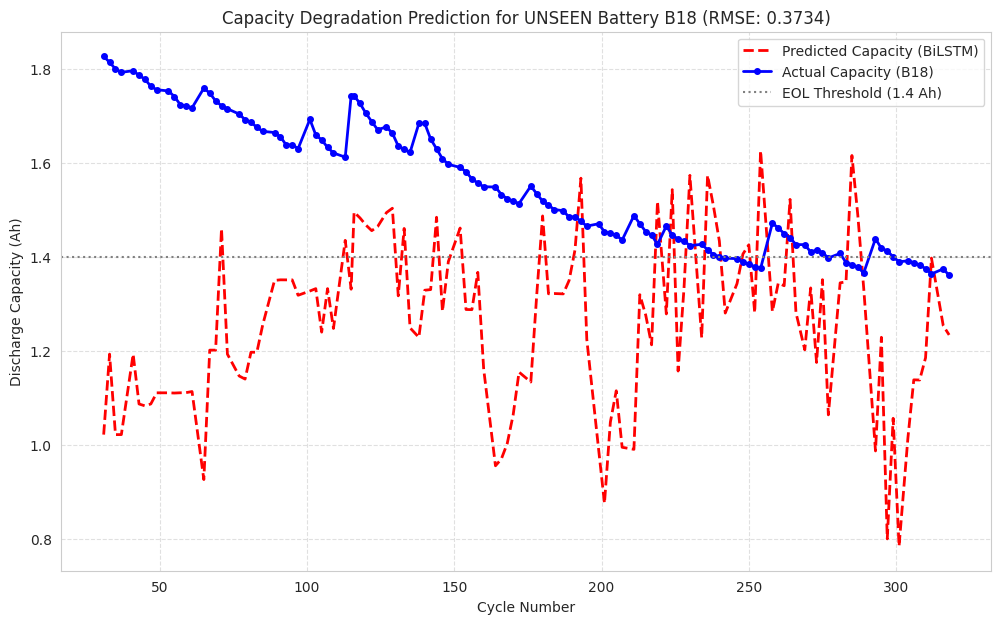


Model is evaluated and plotted.


In [ ]:
# Making Predictions on the UNSEEN Test Set (B18)
Y_pred = bilstm_model.predict(X_test).flatten()
Y_actual = Y_test

# To get the corresponding cycle numbers, we must also discard the first 10 rows of the B18 cycle list. The indices must run from LOOKBACK (10) to the end.
cycles_test = df_test['Cycle'].values[LOOKBACK:]

if len(cycles_test) != len(Y_actual):
    print(f"\nALIGNMENT ERROR REMAINS: Cycles array length ({len(cycles_test)}) does not match prediction array length ({len(Y_actual)}).")
else:
    print(f"\nSUCCESSFUL ALIGNMENT: Cycles and Prediction arrays both have {len(cycles_test)} samples.")

# Final Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

final_rmse = np.sqrt(mean_squared_error(Y_actual, Y_pred))
final_mae = mean_absolute_error(Y_actual, Y_pred)

print("\n--- FINAL UNSEEN B18 TEST RESULTS ---")
print(f"Final RMSE (Unseen B18): {final_rmse:.4f} Ah")
print(f"Final MAE (Unseen B18): {final_mae:.4f} Ah")
print("-" * 40)


# Plotting Predicted vs. Actual Capacity
plt.figure(figsize=(12, 7))

# Plotting the Predicted Capacity (Model's Forecast)
plt.plot(cycles_test, Y_pred,
         label='Predicted Capacity (BiLSTM)',
         color='red',
         linestyle='--',
         linewidth=2)

# Plotting the Actual Capacity (True Degradation Curve)
plt.plot(cycles_test, Y_actual,
         label='Actual Capacity (B18)',
         color='blue',
         linewidth=2,
         marker='o',
         markersize=4)

# Adding EOL Threshold (1.4 Ah)
EOL_THRESHOLD = 2.0 * 0.7
plt.axhline(y=EOL_THRESHOLD, color='gray', linestyle=':', label='EOL Threshold (1.4 Ah)')

plt.title(f'Capacity Degradation Prediction for UNSEEN Battery B18 (RMSE: {final_rmse:.4f})')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nModel is evaluated and plotted.")